In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep
from sklearn.metrics import roc_curve, roc_auc_score

import statsmodels.api as sm
import warnings


In [43]:
warnings.filterwarnings("ignore")

In [44]:
bank = pd.read_csv("bank.csv")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## Data Processing

In [45]:
bank['deposit_num'] = bank['deposit'].map({'yes': 1, 'no': 0})

In [46]:
bank = bank[bank['balance'] >= 0]

In [47]:
categorical_vars = ['job', 'marital', 'education', 'housing', 'loan', 'contact']
for col in categorical_vars:
    bank[col] = bank[col].astype('category')

In [48]:
categorical_vars = ['job', 'marital', 'education', 'housing', 'loan', 'contact']
for col in categorical_vars:
    bank[col] = bank[col].astype('category')

In [49]:
job_rate = bank.groupby('job')['deposit_num'].mean()
job_rate

job
admin.           0.481928
blue-collar      0.374495
entrepreneur     0.365449
housemaid        0.407547
management       0.520147
retired          0.672848
self-employed    0.465116
services         0.399289
student          0.747222
technician       0.470828
unemployed       0.580175
unknown          0.485714
Name: deposit_num, dtype: float64

In [50]:
bank.groupby('deposit_num')['balance'].mean()

deposit_num
0    1423.160148
1    1891.391416
Name: balance, dtype: float64

In [51]:
bank['deposit_num'].value_counts()

deposit_num
0    5395
1    5079
Name: count, dtype: int64

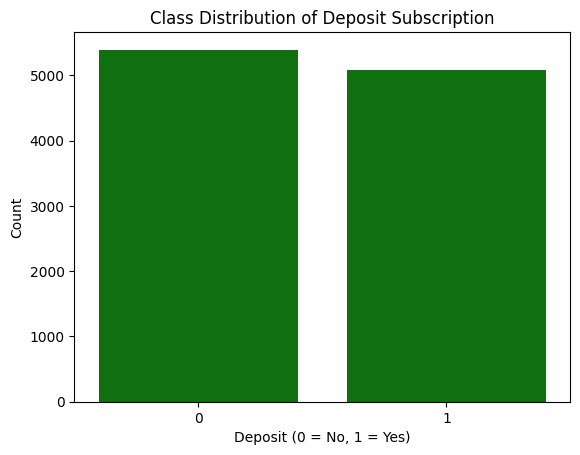

In [52]:
sns.countplot(x='deposit_num', data=bank, color = "Green")
plt.title("Class Distribution of Deposit Subscription")
plt.xlabel("Deposit (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Age groups

In [53]:
bins = [0, 30, 45, 100]
labels = ["<30", "30-45", "45+"]
bank['age_group'] = pd.cut(bank['age'], bins=bins, labels=labels)

In [54]:
bank.groupby('age_group')['deposit_num'].mean()

age_group
<30      0.581507
30-45    0.434656
45+      0.507853
Name: deposit_num, dtype: float64

# Logistic Regression Model

In [55]:
X = bank[['age', 'balance', 'duration', 'previous']].copy()

X.apply(lambda col: col.map(type).unique())

,age,balance,duration,previous
0,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>


In [56]:
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

In [57]:
X.dtypes

age         int64
balance     int64
duration    int64
previous    int64
dtype: object

In [58]:

X = pd.concat([
    X,
    pd.get_dummies(bank['housing'], prefix='housing', drop_first=True),
    pd.get_dummies(bank['loan'], prefix='loan', drop_first=True)
], axis=1)

X = X.apply(pd.to_numeric, errors='coerce')
y = bank['deposit_num'].astype(float)

valid_idx = X.dropna().index
X = X.loc[valid_idx]
y = y.loc[valid_idx]


X_np = X.to_numpy().astype(float)
y_np = y.to_numpy().astype(float)

X_np = sm.add_constant(X_np)


model = sm.Logit(y_np, X_np).fit(maxiter=200)
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.513981
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                10474
Model:                          Logit   Df Residuals:                    10467
Method:                           MLE   Df Model:                            6
Date:                Fri, 12 Dec 2025   Pseudo R-squ.:                  0.2580
Time:                        14:44:12   Log-Likelihood:                -5383.4
converged:                       True   LL-Null:                       -7255.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1551      0.094    -12.240      0.000      -1.340      -0.970
x1            -0.0023      0.

In [59]:
feature_names = ['age', 'balance', 'duration', 'previous', 'housing_yes', 'loan_yes']

coef_table = pd.DataFrame({
    'feature': ['const'] + feature_names,
    'coef':    model.params,
    'pvalue':  model.pvalues
})

coef_table

,feature,coef,pvalue
0,const,-1.155076,1.889748e-34
1,age,-0.002269,2.439807e-01
2,balance,0.000033,2.187511e-05
3,duration,0.004652,0.000000e+00
4,previous,0.222357,1.560659e-60
5,housing_yes,-1.206635,3.325444e-128
6,loan_yes,-0.784238,1.794404e-22


In [60]:
model = LogisticRegression(max_iter=500)
model.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [61]:
coeffs = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
coeffs

,Feature,Coefficient
0,age,-0.002249
1,balance,0.000033
2,duration,0.004649
3,previous,0.222230
4,housing_yes,-1.203650
5,loan_yes,-0.779294


In [62]:
bank['predicted_prob'] = model.predict_proba(X)[:, 1]
bank['predicted_class'] = (bank['predicted_prob'] > 0.5).astype(int)

In [63]:
# y_true = actual values
# y_pred = predicted class (0/1)

y_true = bank.loc[X.index, 'deposit_num']
y_pred = bank.loc[X.index, 'predicted_class']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      5395
           1       0.78      0.71      0.75      5079

    accuracy                           0.76     10474
   macro avg       0.77      0.76      0.76     10474
weighted avg       0.77      0.76      0.76     10474



## Regression Models' Confussion Matrix

In [64]:
cm = confusion_matrix(bank['deposit_num'], bank['predicted_class'])
acc = accuracy_score(bank['deposit_num'], bank['predicted_class'])

print("Confusion Matrix:\n", cm)
print("Accuracy:", acc)

Confusion Matrix:
 [[4384 1011]
 [1463 3616]]
Accuracy: 0.7637960664502578


In [65]:

y_true = bank.loc[X.index, 'deposit_num']
y_pred = bank.loc[X.index, 'predicted_class']

print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))

Precision: 0.7814998919386211
Recall: 0.7119511714904508
F1-score: 0.7451061199258191


# A/B testing

In [66]:
A_calls = len(bank)
A_deposits = bank['deposit_num'].sum()
A_rate = A_deposits / A_calls

In [67]:
B_group = bank[bank['predicted_prob'] > 0.5]

B_calls = len(B_group)
B_deposits = B_group['deposit_num'].sum()
B_rate = B_deposits / B_calls

In [68]:
AB_results = pd.DataFrame({
    'Strategy': ['A: Call Everyone', 'B: Call High-Prob Only'],
    'Calls': [A_calls, B_calls],
    'Deposits': [A_deposits, B_deposits],
    'Conversion Rate': [A_rate, B_rate]
})

AB_results

,Strategy,Calls,Deposits,Conversion Rate
0,A: Call Everyone,10474,5079,0.484915
1,B: Call High-Prob Only,4627,3616,0.781500


## Hypothesis testing for A/B testing

In [69]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep

ALPHA = 0.05

# Use your computed values (NOT hard-coded)
count = [A_deposits, B_deposits]
nobs  = [A_calls, B_calls]

# 1) Z-test for proportions
zstat, pval = sm.stats.proportions_ztest(count, nobs)
print("Z-Test for Proportions")
print("Z-statistic:", zstat)
print("p-value:", pval)

if pval < ALPHA:
    print("Reject H0: conversion rates are significantly different.")
else:
    print("Fail to reject H0.")

print()

# 2) Chi-squared test (like instructor)
chi2_stat, chi2_pval, _ = proportions_chisquare(count=count, nobs=nobs)
print("Chi-Squared Test")
print("Chi-square statistic:", chi2_stat)
print("p-value:", chi2_pval)

if chi2_pval < ALPHA:
    print("Reject H0: conversion rates are significantly different.")
else:
    print("Fail to reject H0.")

print()

# 3) Confidence interval for difference (B - A)
ci_low, ci_high = confint_proportions_2indep(
    count1=B_deposits, nobs1=B_calls,
    count2=A_deposits, nobs2=A_calls,
    method="wald"
)

absolute_diff = B_rate - A_rate
relative_lift = absolute_diff / A_rate * 100

print("Final Result w/ Confidence Interval")
print(f"Strategy A rate: {A_rate:.4f}")
print(f"Strategy B rate: {B_rate:.4f}")
print(f"Absolute difference (B - A): {absolute_diff:.4f}")
print(f"Relative lift: {relative_lift:.1f}%")
print(f"95% CI (absolute diff): ({ci_low:.4f}, {ci_high:.4f})")

Z-Test for Proportions
Z-statistic: -33.99614020725025
p-value: 2.5404781207641313e-253
Reject H0: conversion rates are significantly different.

Chi-Squared Test
Chi-square statistic: 1155.7375489910169
p-value: 2.5404781207644896e-253
Reject H0: conversion rates are significantly different.

Final Result w/ Confidence Interval
Strategy A rate: 0.4849
Strategy B rate: 0.7815
Absolute difference (B - A): 0.2966
Relative lift: 61.2%
95% CI (absolute diff): (0.2813, 0.3119)


In [70]:
cluster_data = bank[['age', 'balance', 'duration', 'previous']].copy()

In [71]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

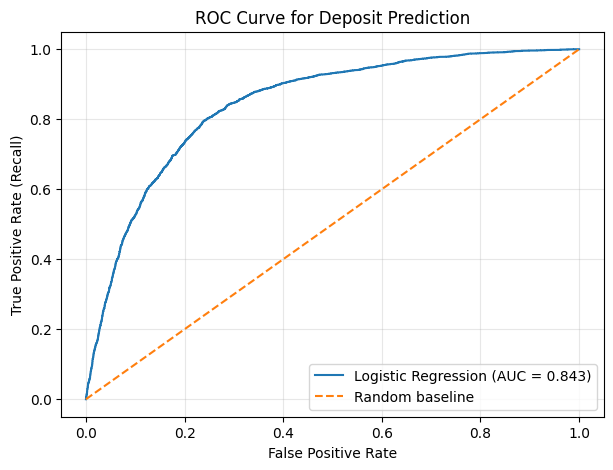

In [72]:
y_true = bank['deposit_num'].astype(int)

y_score = bank['predicted_prob'].astype(float)

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for Deposit Prediction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Elbow Method

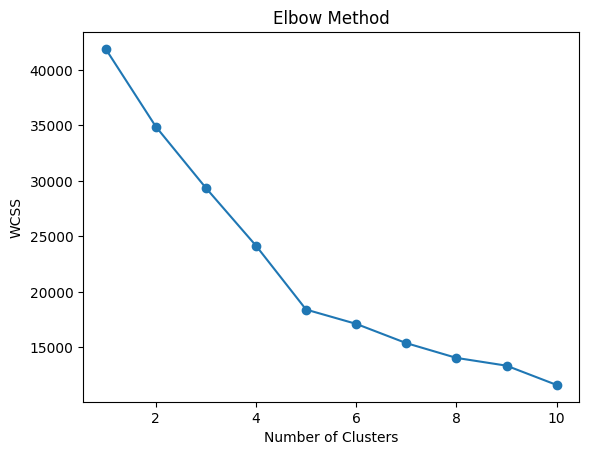

In [73]:
wcss = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(cluster_scaled)
    wcss.append(km.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Silhouette Score

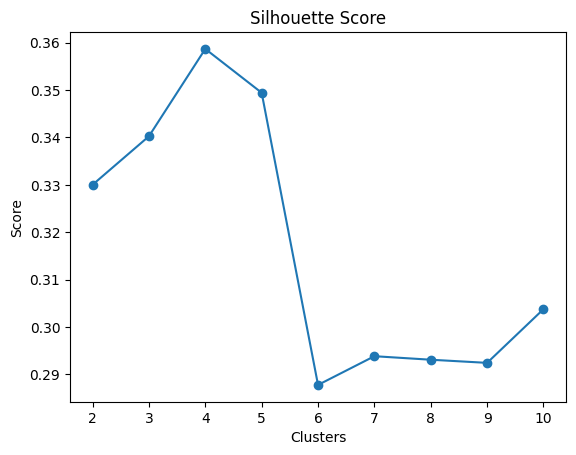

In [74]:
sil = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(cluster_scaled)
    sil.append(silhouette_score(cluster_scaled, labels))

plt.plot(range(2, 11), sil, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Clusters')
plt.ylabel('Score')
plt.show()

# K-Means segmentation

In [75]:
k4 = KMeans(n_clusters=4, random_state=42)
bank['cluster'] = k4.fit_predict(cluster_scaled)
bank['cluster'] = bank['cluster'].astype('category')

In [76]:
cluster_summary = bank.groupby('cluster').agg({
    'age': 'mean',
    'balance': 'mean',
    'duration': 'mean',
    'previous': 'mean',
    'deposit_num': 'mean'
})

cluster_summary

,age,balance,duration,previous,deposit_num
cluster,,,,,
0,42.271881,1519.445065,334.154562,8.255121,0.698324
1,41.181558,1179.667143,231.134026,0.477013,0.377143
2,41.011446,1397.063996,947.194589,0.339230,0.845473
3,45.717460,14919.968254,340.682540,0.698413,0.555556


# KNN Confusion Matrix 

In [77]:
X = bank[['age', 'balance', 'duration', 'previous']].copy()

X = pd.concat([
    X,
    pd.get_dummies(bank['housing'], prefix='housing', drop_first=True),
    pd.get_dummies(bank['loan'], prefix='loan', drop_first=True)
], axis=1)

y = bank['deposit_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

knn_pred = knn.predict(X_test_scaled)

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_cm = confusion_matrix(y_test, knn_pred)

print("KNN Accuracy:", knn_accuracy)
print("\nConfusion Matrix:")
print(knn_cm)

KNN Accuracy: 0.762010817690105

Confusion Matrix:
[[1233  376]
 [ 372 1162]]


## Logistic Regression vs KNN

In [78]:

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
log_pred = log_model.predict(X_test_scaled)

log_accuracy = accuracy_score(y_test, log_pred)

print("\nLogistic Regression Accuracy:", log_accuracy)
print("\nKNN Accuracy:", knn_accuracy)


Logistic Regression Accuracy: 0.7712376710149539

KNN Accuracy: 0.762010817690105


In [81]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=sns.color_palette("Greens", as_cmap=True),
        xticklabels=["Predicted No", "Predicted Yes"],
        yticklabels=["Actual No", "Actual Yes"]
    )
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

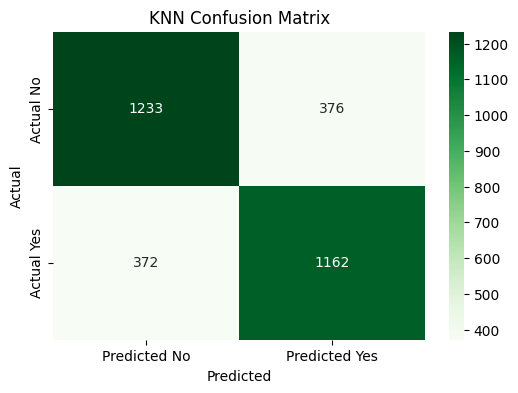

In [82]:
cm_knn = confusion_matrix(y_test, knn_pred)
plot_confusion_matrix(cm_knn, "KNN Confusion Matrix")

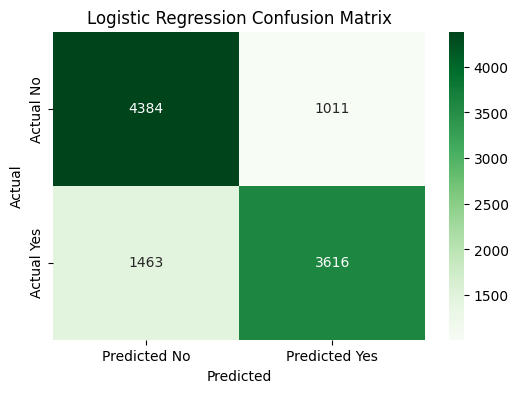

In [83]:
cm_log = confusion_matrix(bank.loc[X.index, 'deposit_num'], bank.loc[X.index, 'predicted_class'])
plot_confusion_matrix(cm_log, "Logistic Regression Confusion Matrix")